# Problem Set - Gaussian Processes 

In [66]:
# The modules we will be using in this problem set
import util, test # These are local modules please feel free to read through them
from importlib import reload
reload(util)
reload(test)
import numpy as np
import matplotlib.pyplot as plt

## Gaussian Processes##

In this problem set, you will gain a deeper understanding of how gaussian processes work by working on building a small library for guassian regression and classification. If you are having serious problems with this Pset please feel free to ask on Piazza or refer to [Gaussian Proccess: A Quick Introduction](A Quick Intro To Gaussian Proccesses.pdf).

### Problems
1. [Part 1 - Overveiw](#Part-1---Overveiw)
  1. [Problem 1 (10 pts)](#Problem-1---Making-a-Simple-Kernal-%2810-pts%29)
  2. [Problem 2 (5 pts)](#Problem-2---Making-a-Periodic-Kernal-%285-pts%29)
2. [Part 2 - Regression](#Part-2---Regression)
3. [Part 3 - Classification](#Part-3---Classification)

# Part 1 - Overveiw

Say something Here

## Problem 1 - Making a Simple Kernel (10 pts)

In [45]:
def kernel(x0, x1, params, sigma_n):
    diff = np.subtract.outer(x0, x1)
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2)
    value[np.where(diff == 0.0)] += sigma_n**2
    return value

In [46]:
test.test_simple_kernel(kernel)

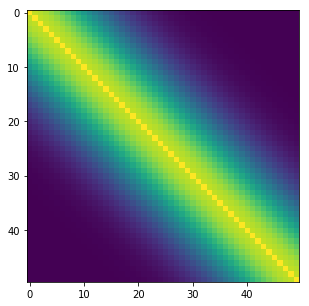

In [47]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2]
K = kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

## Problem 2 - Making a Periodic Kernel (5 pts)

In [48]:
def periodic_kernel(x0, x1, params, sigma_n):
    diff = np.subtract.outer(x0, x1)
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2)
    value += params[2]**2 * np.exp(-2 * np.sin(params[3]*diff)**2)
    value[np.where(diff == 0.0)] += sigma_n**2
    return value

In [49]:
test.test_periodic_kernel(periodic_kernel)

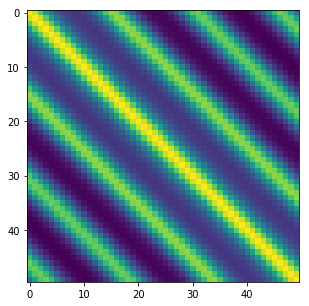

In [50]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2, 2, 1]
K = periodic_kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

# Part 2 - Regression

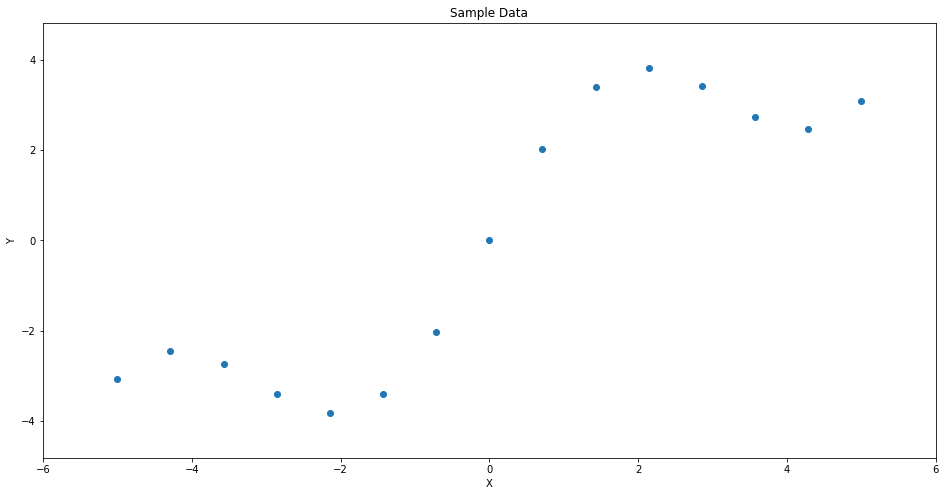

In [51]:
x, y = util.get_sample_data_1()
util.scatter_raw_data(x, y)

## Problem 3 - Getting K Matrix (5 pts)

In [52]:
def get_Ks(x_new, x, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    return K, KS, KSS

In [53]:
test.test_get_Ks(get_Ks, kernel)

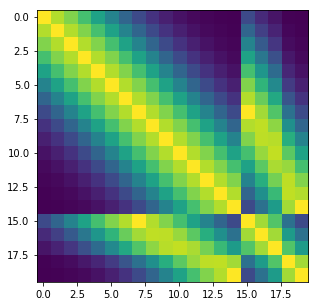

In [54]:
theta = [1, 3, 0.1]
x_new = np.array([0, 1, 2, 4, 5])
K, KS, KSS = get_Ks(x_new, x, kernel, theta)
util.visiualize_Ks(K, KS, KSS)

## Problem 4 - Regression GP (20 pts)

In [55]:
def regression_GP(x_new, x, y, kernel, theta):
    K, KS, KSS = get_Ks(x_new, x, kernel, theta)

    y = np.matmul(np.matmul(KS, np.linalg.inv(K)),y)
    var = KSS - KS.dot(np.linalg.inv(K).dot(KS.T))
    var = np.diagonal(var)
    return(y.squeeze(), var.squeeze())

In [63]:
test.test_regression(regression_GP, kernel)

## Problem 5 - Manual Parameter Tuning (5 pts)

# Part 3 - Classification

## Problem 6

Description of a sigmoid function
<center>$S(x)$ = $\dfrac{1}{1+e^{-x}}$</center>
In this PSet use $S(x)$ as the sigmoid functiod in the implementation of the following problems

Implement $S(x)$.

In [60]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [65]:
test.test_sigmoid(sigmoid)

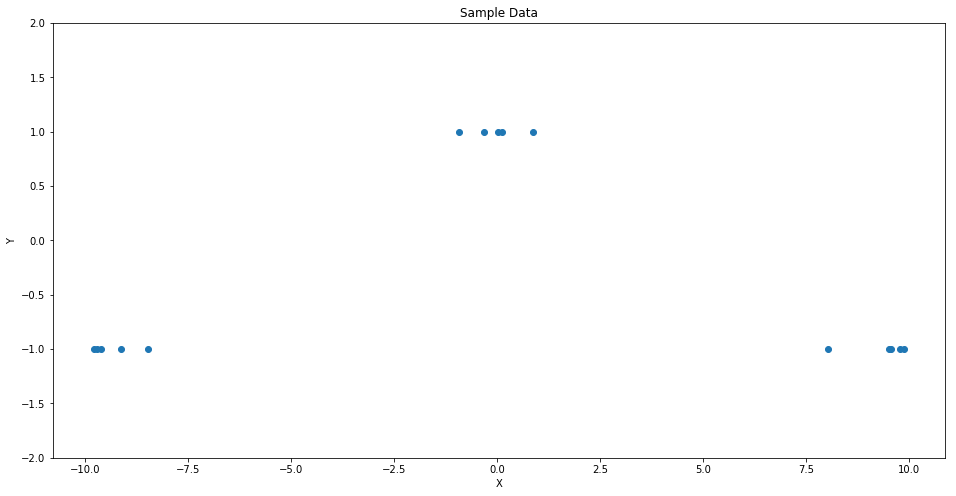

In [67]:
x, y = util.get_sample_classification_data()
util.scatter_raw_data(x, y)

Solve for the covariance matrices K, K$*$, and K$**$ using the function you implemented above

In [35]:
theta = [.4, 5, 0]
K, KS, KSS = get_Ks(x, x, kernel, theta)

In [ ]:
test.test_get_Ks(get_Ks, kernel)

Find f

In [36]:
def find_f(K, y):
    n = len(y) 
    f = np.zeros(n)  
    y_giv_f = np.zeros(n)
    grad = np.zeros(n)
    
    for i in range(0, 100):
        for j in range(n):
            y_giv_f[j] = sigmoid(f[j]*y[j])
            grad[j] = (1-y_giv_f[j])*y[j]
        f = np.array(np.matmul(K, grad)).flatten()
    for j in range(n):
        y_giv_f[j] = sigmoid(f[j]*y[j])
    return f, y_giv_f

Write a function that solves for W given f and y

In [37]:
def calc_W(f, y):
    n = len(y)
    W = np.zeros(n)
    for j in range(n):
        sigmoid_v = sigmoid(f[j]*y[j])
        W[j] = y[j]**2 * (1-sigmoid_v)*sigmoid_v
    return W

Write a function that solves for $K'$

In [38]:
def calculate_KP(K, W):
    return K + (1.0/W)

Now we have all the necessary components. 

In [39]:
def GP(x_new, x, y, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    
    f, y_giv_f = find_f(K, y)
    W = calculate_W(f, y)
    
    KP = calculate_KP(K, W)

    f_bar = np.matmul(np.matmul(KS, np.linalg.inv(K)), f)    
    var = KSS - KS.dot(np.linalg.inv(KP).dot(KS.T))
    var = np.diagonal(var)
    return(f_bar.squeeze(), var.squeeze())

We provided you with $\theta$, now write a function that optimizes $\theta$ for you. Ouput of function is a list.

In [40]:
def optimize_theta(x, y, kernel, params_0=[0.1, 0.1], sigma_n=0.1):
    def log_pY(theta):
        K = np.matrix(kernel(x, x, theta, sigma_n))
        f, y_giv_f = find_f(K, y, 100)
        W = calculate_W(f, y)
        inv_k = np.linalg.inv(K)
        log_k = np.log(np.linalg.det(K) * np.linalg.det(inv_k+W))
        Y_giv_f = np.prod(y_giv_f)
        output = 0.5 * np.matmul(np.matmul(f.T, inv_k),f)
        output += 0.5 * log_k
        output -= np.log(Y_giv_f)
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]